# **Time Series Characterization**

## _ETL Workflow Notebook 4_

## Content:
1. Lag-diagnosis: obtaining autocorrelation (ACF) and partial autocorrelation function (PACF) plots of the time series; 
2. Obtaining the 'd' parameter of ARIMA (p, q, d) model; 
3. Obtaining the best ARIMA (p, q, d) model; 
4. Forecasting with ARIMA model;
5. Forecasting with Facebook Prophet model;
6. Obtaining rolling window statistics of the dataframe; 
7. Decomposing seasonality and trend of the time series.

Marco Cesar Prado Soares, Data Scientist Specialist - Bayer Crop Science LATAM
- marcosoares.feq@gmail.com
- marco.soares@bayer.com

In [ ]:
# To install a library (e.g. tensorflow), unmark and run:
# ! pip install tensorflow
# to update a library (e.g. tensorflow), unmark and run:
# ! pip install tensorflow --upgrade
# to update pip, unmark and run:
# ! pip install pip --upgrade
# to show if a library is installed and visualize its information, unmark and run
# (e.g. tensorflow):
# ! pip show tensorflow
# To run a Python file (e.g idsw_etl.py) saved in the notebook's workspace directory,
# unmark and run:
# import idsw_etl
# or:
# import idsw_etl as etl

## **Load Python Libraries in Global Context**

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
# Import all needed functions and classes with original names, with no aliases:
from idsw import *

## **Call the functions**

### **Mounting Google Drive or S3 (AWS Simple Storage Service) bucket**

In [ ]:
SOURCE = 'aws'
# SOURCE = 'google' for mounting the google drive;
# SOURCE = 'aws' for accessing an AWS S3 bucket

## THE FOLLOWING PARAMETERS HAVE EFFECT ONLY WHEN SOURCE == 'aws':

PATH_TO_STORE_IMPORTED_S3_BUCKET = ''
# PATH_TO_STORE_IMPORTED_S3_BUCKET: path of the Python environment to which the
# S3 bucket contents will be imported. If it is None; or if it is an empty string; or if 
# PATH_TO_STORE_IMPORTED_S3_BUCKET = '/', bucket will be imported to the root path. 
# Alternatively, input the path as a string (in quotes). e.g. 
# PATH_TO_STORE_IMPORTED_S3_BUCKET = 'copied_s3_bucket'

S3_BUCKET_NAME = 'my_bucket'
## This parameter is obbligatory to access an AWS S3 bucket. Substitute it for a string
# with the bucket's name. e.g. s3_bucket_name = "aws-bucket-1" access a bucket named as
# "aws-bucket-1"

S3_OBJECT_FOLDER_PREFIX = ""
# S3_OBJECT_FOLDER_PREFIX = None. Keep it None; or as an empty string 
# (S3_OBJECT_FOLDER_PREFIX = ''); or as the root "/" to import the 
# whole bucket content, instead of a single object from it.
# Alternatively, set it as a string containing the subfolder from the bucket to import:
# Suppose that your bucket (admin-created) has four objects with the following object 
# keys: Development/Projects1.xls; Finance/statement1.pdf; Private/taxdocument.pdf; and
# s3-dg.pdf. 
# The s3-dg.pdf key does not have a prefix, so its object appears directly 
# at the root level of the bucket. If you open the Development/ folder, you see 
# the Projects.xlsx object in it.
# In summary, if the path of the file is: 'bucket/my_path/.../file.csv'
# where 'bucket' is the bucket's name, prefix = 'my_path/.../', without the
# 'file.csv' (file name with extension) last part.

# So, declare the prefix as S3_OBJECT_FOLDER_PREFIX to import only files from
# a given folder (directory) of the bucket.
# DO NOT PUT A SLASH before (to the right of) the prefix;
# DO NOT ADD THE BUCKET'S NAME TO THE right of the prefix:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/"

# Alternatively, provide the full path of a given file if you want to import only it:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/my_file.ext"
# where my_file is the file's name, and ext is its extension.


# Attention: after running this function for fetching AWS Simple Storage System (S3), 
# your 'AWS Access key ID' and your 'Secret access key' will be requested.
# The 'Secret access key' will be hidden through dots, so it cannot be visualized or copied by
# other users. On the other hand, the same is not true for 'Access key ID', the bucket's name 
# and the prefix. All of these are sensitive information from the organization.
# Therefore, after importing the information, always remember of cleaning the output of this cell
# and of removing such information from the strings.
# Remember that these data may contain privilege for accessing protected information, 
# so it should not be used for non-authorized people.

# Also, remember of deleting the imported files from the workspace after finishing the analysis.
# The costs for storing the files in S3 is quite inferior than those for storing directly in the
# workspace. Also, files stored in S3 may be accessed for other users than those with access to
# the notebook's workspace.
mount_storage_system (source = SOURCE, path_to_store_imported_s3_bucket = PATH_TO_STORE_IMPORTED_S3_BUCKET, s3_bucket_name = S3_BUCKET_NAME, s3_obj_prefix = S3_OBJECT_FOLDER_PREFIX)

### **Importing the dataset**

In [ ]:
## WARNING: Use this function to load dataframes stored on Excel (xls, xlsx, xlsm, xlsb, odf, ods and odt), 
## JSON, txt, or CSV (comma separated values) files. Tables in webpages or html files can also be read.

FILE_DIRECTORY_PATH = ""
# FILE_DIRECTORY_PATH - (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file is stored. e.g. FILE_DIRECTORY_PATH = "" 
# or FILE_DIRECTORY_PATH = "folder"

FILE_NAME_WITH_EXTENSION = "dataset.csv"
# FILE_NAME_WITH_EXTENSION - (string, in quotes): input the name of the file with the 
# extension. e.g. FILE_NAME_WITH_EXTENSION = "file.xlsx", or, 
# FILE_NAME_WITH_EXTENSION = "file.csv", "file.txt", or "file.json"
# Again, the extensions may be: xls, xlsx, xlsm, xlsb, odf, ods, odt, json, txt or csv.
# Also, html files and webpages may be also read.

# You may input the path for an HTML file containing a table to be read; or 
# a string containing the address for a webpage containing the table. The address must start
# with www or htpp. If a website is input, the full address can be input as FILE_DIRECTORY_PATH
# or as FILE_NAME_WITH_EXTENSION.

LOAD_TXT_FILE_WITH_JSON_FORMAT = False
# LOAD_TXT_FILE_WITH_JSON_FORMAT = False. Set LOAD_TXT_FILE_WITH_JSON_FORMAT = True 
# if you want to read a file with txt extension containing a text formatted as JSON 
# (but not saved as JSON).
# WARNING: if LOAD_TXT_FILE_WITH_JSON_FORMAT = True, all the JSON file parameters of the 
# function (below) must be set. If not, an error message will be raised.

HOW_MISSING_VALUES_ARE_REGISTERED = None
# HOW_MISSING_VALUES_ARE_REGISTERED = None: keep it None if missing values are registered as None,
# empty or np.nan. Pandas automatically converts None to NumPy np.nan objects (floats).
# This parameter manipulates the argument na_values (default: None) from Pandas functions.
# By default the following values are interpreted as NaN: ‘’, ‘#N/A’, ‘#N/A N/A’, ‘#NA’, ‘-1.#IND’, 
#‘-1.#QNAN’, ‘-NaN’, ‘-nan’, ‘1.#IND’, ‘1.#QNAN’, ‘<NA>’, ‘N/A’, ‘NA’, ‘NULL’, ‘NaN’, 
# ‘n/a’, ‘nan’, ‘null’.

# If a different denomination is used, indicate it as a string. e.g.
# HOW_MISSING_VALUES_ARE_REGISTERED = '.' will convert all strings '.' to missing values;
# HOW_MISSING_VALUES_ARE_REGISTERED = 0 will convert zeros to missing values.

# If dict passed, specific per-column NA values. For example, if zero is the missing value
# only in column 'numeric_col', you can specify the following dictionary:
# how_missing_values_are_registered = {'numeric-col': 0}

    
HAS_HEADER = True
# HAS_HEADER = True if the the imported table has headers (row with columns names).
# Alternatively, HAS_HEADER = False if the dataframe does not have header.

DECIMAL_SEPARATOR = '.'
# DECIMAL_SEPARATOR = '.' - String. Keep it '.' or None to use the period ('.') as
# the decimal separator. Alternatively, specify here the separator.
# e.g. DECIMAL_SEPARATOR = ',' will set the comma as the separator.
# It manipulates the argument 'decimal' from Pandas functions.

TXT_CSV_COL_SEP = "comma"
# txt_csv_col_sep = "comma" - This parameter has effect only when the file is a 'txt'
# or 'csv'. It informs how the different columns are separated.
# Alternatively, txt_csv_col_sep = "comma", or txt_csv_col_sep = "," 
# for columns separated by comma;
# txt_csv_col_sep = "whitespace", or txt_csv_col_sep = " " 
# for columns separated by simple spaces.
# You can also set a specific separator as string. For example:
# txt_csv_col_sep = '\s+'; or txt_csv_col_sep = '\t' (in this last example, the tabulation
# is used as separator for the columns - '\t' represents the tab character).

## Parameters for loading Excel files:

LOAD_ALL_SHEETS_AT_ONCE = False
# LOAD_ALL_SHEETS_AT_ONCE = False - This parameter has effect only when for Excel files.
# If LOAD_ALL_SHEETS_AT_ONCE = True, the function will return a list of dictionaries, each
# dictionary containing 2 key-value pairs: the first key will be 'sheet', and its
# value will be the name (or number) of the table (sheet). The second key will be 'df',
# and its value will be the pandas dataframe object obtained from that sheet.
# This argument has preference over SHEET_TO_LOAD. If it is True, all sheets will be loaded.
    
SHEET_TO_LOAD = None
# SHEET_TO_LOAD - This parameter has effect only when for Excel files.
# keep SHEET_TO_LOAD = None not to specify a sheet of the file, so that the first sheet
# will be loaded.
# SHEET_TO_LOAD may be an integer or an string (inside quotes). SHEET_TO_LOAD = 0
# loads the first sheet (sheet with index 0); SHEET_TO_LOAD = 1 loads the second sheet
# of the file (index 1); SHEET_TO_LOAD = "Sheet1" loads a sheet named as "Sheet1".
# Declare a number to load the sheet with that index, starting from 0; or declare a
# name to load the sheet with that name.

## Parameters for loading JSON files:

JSON_RECORD_PATH = None
# JSON_RECORD_PATH (string): manipulate parameter 'record_path' from json_normalize method.
# Path in each object to list of records. If not passed, data will be assumed to 
# be an array of records. If a given field from the JSON stores a nested JSON (or a nested
# dictionary) declare it here to decompose the content of the nested data. e.g. if the field
# 'books' stores a nested JSON, declare, JSON_RECORD_PATH = 'books'

JSON_FIELD_SEPARATOR = "_"
# JSON_FIELD_SEPARATOR = "_" (string). Manipulates the parameter 'sep' from json_normalize method.
# Nested records will generate names separated by sep. 
# e.g., for JSON_FIELD_SEPARATOR = ".", {‘foo’: {‘bar’: 0}} -> foo.bar.
# Then, if a given field 'main_field' stores a nested JSON with fields 'field1', 'field2', ...
# the name of the columns of the dataframe will be formed by concatenating 'main_field', the
# separator, and the names of the nested fields: 'main_field_field1', 'main_field_field2',...

JSON_METADATA_PREFIX_LIST = None
# JSON_METADATA_PREFIX_LIST: list of strings (in quotes). Manipulates the parameter 
# 'meta' from json_normalize method. Fields to use as metadata for each record in resulting 
# table. Declare here the non-nested fields, i.e., the fields in the principal JSON. They
# will be repeated in the rows of the dataframe to give the metadata (context) of the rows.

# e.g. Suppose a JSON with the following structure: {'name': 'Mary', 'last': 'Shelley',
# 'books': [{'title': 'Frankestein', 'year': 1818}, {'title': 'Mathilda ', 'year': 1819},{'title': 'The Last Man', 'year': 1826}]},
# Here, there are nested JSONs in the field 'books'. The fields that are not nested
# are 'name' and 'last'.
# Then, JSON_RECORD_PATH = 'books'
# JSON_METADATA_PREFIX_LIST = ['name', 'last']


# The dataframe will be stored in the object named 'dataset':
# Simply modify this object on the left of equality:
dataset = load_pandas_dataframe (file_directory_path = FILE_DIRECTORY_PATH, file_name_with_extension = FILE_NAME_WITH_EXTENSION, load_txt_file_with_json_format = LOAD_TXT_FILE_WITH_JSON_FORMAT, how_missing_values_are_registered = HOW_MISSING_VALUES_ARE_REGISTERED, has_header = HAS_HEADER, decimal_separator = DECIMAL_SEPARATOR, txt_csv_col_sep = TXT_CSV_COL_SEP, load_all_sheets_at_once = LOAD_ALL_SHEETS_AT_ONCE, sheet_to_load = SHEET_TO_LOAD, json_record_path = JSON_RECORD_PATH, json_field_separator = JSON_FIELD_SEPARATOR, json_metadata_prefix_list = JSON_METADATA_PREFIX_LIST)

# OBS: If an Excel file is loaded and LOAD_ALL_SHEETS_AT_ONCE = True, then the object
# dataset will be a list of dictionaries, with 'sheet' as key containing the sheet name; and 'df'
# as key correspondent to the Pandas dataframe. So, to access the 3rd dataframe (index 2, since
# indexing starts from zero): df = dataframe[2]['df'], where dataframe is the list returned.

### **Converting JSON object to dataframe**
- Objects may be:
    - String with JSON formatted text;
    - List with nested dictionaries (JSON formatted);
    - Each dictionary may contain nested dictionaries, or nested lists of dictionaries (nested JSON).

In [ ]:
# JSON object in terms of Python structure: list of dictionaries, where each value of a
# dictionary may be a dictionary or a list of dictionaries (nested structures).
# example of highly nested structure saved as a list 'json_formatted_list'. Note that the same
# structure could be declared and stored into a string variable. For instance, if you have a txt
# file containing JSON, you could read the txt and save its content as a string.
# json_formatted_list = [{'field1': val1, 'field2': {'dict_val': dict_val}, 'field3': [{
# 'nest1': nest_val1}, {'nest2': nestval2}]}, {'field1': val1, 'field2': {'dict_val': dict_val}, 
# 'field3': [{'nest1': nest_val1}, {'nest2': nestval2}]}]

JSON_OBJ_TO_CONVERT = json_object #Alternatively: object containing the JSON to be converted

# JSON_OBJ_TO_CONVERT: object containing JSON, or string with JSON content to parse.
# Objects may be: string with JSON formatted text;
# list with nested dictionaries (JSON formatted);
# dictionaries, possibly with nested dictionaries (JSON formatted).

JSON_OBJ_TYPE = 'list'
# JSON_OBJ_TYPE = 'list', in case the object was saved as a list of dictionaries (JSON format)
# JSON_OBJ_TYPE = 'string', in case it was saved as a string (text) containing JSON.

## Parameters for loading JSON files:

JSON_RECORD_PATH = None
# JSON_RECORD_PATH (string): manipulate parameter 'record_path' from json_normalize method.
# Path in each object to list of records. If not passed, data will be assumed to 
# be an array of records. If a given field from the JSON stores a nested JSON (or a nested
# dictionary) declare it here to decompose the content of the nested data. e.g. if the field
# 'books' stores a nested JSON, declare, JSON_RECORD_PATH = 'books'

JSON_FIELD_SEPARATOR = "_"
# JSON_FIELD_SEPARATOR = "_" (string). Manipulates the parameter 'sep' from json_normalize method.
# Nested records will generate names separated by sep. 
# e.g., for JSON_FIELD_SEPARATOR = ".", {‘foo’: {‘bar’: 0}} -> foo.bar.
# Then, if a given field 'main_field' stores a nested JSON with fields 'field1', 'field2', ...
# the name of the columns of the dataframe will be formed by concatenating 'main_field', the
# separator, and the names of the nested fields: 'main_field_field1', 'main_field_field2',...

JSON_METADATA_PREFIX_LIST = None
# JSON_METADATA_PREFIX_LIST: list of strings (in quotes). Manipulates the parameter 
# 'meta' from json_normalize method. Fields to use as metadata for each record in resulting 
# table. Declare here the non-nested fields, i.e., the fields in the principal JSON. They
# will be repeated in the rows of the dataframe to give the metadata (context) of the rows.

# e.g. Suppose a JSON with the following structure: [{'name': 'Mary', 'last': 'Shelley',
# 'books': [{'title': 'Frankestein', 'year': 1818}, {'title': 'Mathilda ', 'year': 1819},{'title': 'The Last Man', 'year': 1826}]}]
# Here, there are nested JSONs in the field 'books'. The fields that are not nested
# are 'name' and 'last'.
# Then, JSON_RECORD_PATH = 'books'
# JSON_METADATA_PREFIX_LIST = ['name', 'last']


# The dataframe will be stored in the object named 'dataset':
# Simply modify this object on the left of equality:
dataset = json_obj_to_pandas_dataframe (json_obj_to_convert = JSON_OBJ_TO_CONVERT, json_obj_type = JSON_OBJ_TYPE, json_record_path = JSON_RECORD_PATH, json_field_separator = JSON_FIELD_SEPARATOR, json_metadata_prefix_list = JSON_METADATA_PREFIX_LIST)

## **Convert iterable to a single-column dataframe**
- Use this function to convert an iterable (array, list, tuple, etc) into a single-column Pandas dataframe, so that you may directly apply each one of the ETL functions below to this iterable, with no modifications.
- Notice that the input of a string will result in a dataframe where each row contains a character.

In [ ]:
ITERABLE = list_to_be_converted
# iterable: object to be converted (list, tuple, array, etc). Input an object here.

COLUMN_LABEL = 'column1'
# column_lable = string with the name that the column will receive.
# Example: column_label = 'column1' will create a dataframe with a column named as 'column1'

COLUMN_TYPE = None
# column_type = None
# Set a specific type for the column: int, str, float, np.datetime64, 'datetime64[ns]', etc.
# Examples: column_type = str; column_type = np.float64; column_type = np.datetime64; 
# column_type = int, column_type = 'datetime64[ns]'
# When the parameter is passed, the column will be set as it. If not, the standard read format
# will be used.


# The dataframe will be stored in the object named 'single_column_df':
# Simply modify this object on the left of equality:
single_column_df = convert_variable_or_iterable_to_single_column_df (iterable = ITERABLE, column_label = COLUMN_LABEL, column_type = COLUMN_TYPE)

## **Set schema of a Pandas dataframe**
- Use this function to set the schema (column types) of a Pandas dataframe.
- You may set only some of the columns; a single column; or no column, keeping others as default.

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

SCHEMA_LIST = [
    
    {'column_name': None, 'column_type': None},
    {'column_name': None, 'column_type': None},
    {'column_name': None, 'column_type': None},
    {'column_name': None, 'column_type': None},
    {'column_name': None, 'column_type': None},
    {'column_name': None, 'column_type': None},
    {'column_name': None, 'column_type': None},
    
]
# schema_list: list of dictionaries containing the columns' names and the types they
# must have. Add a new dictionary for each column to have its type modified, but
# keep always the same keys. If one or two keys are None or with an invalid type,
# the column will be ignored., Add as much dictionaries as you want as elements from the list.
# Examples of column types: column_type: str; column_type: np.float64; 
# column_type: np.datetime64; column_type: int
# Examples of schema_list:
# schema_list = [{'column_name': 'column1', 'column_type': str}] will only set 'column1' as string.
# schema_list = [{'column_name': 'column1', 'column_type': 'datetime64[ns]'},
# {'column_name': 'column2', 'column_type': str},
# {'column_name': 'column3', 'column_type': float},] will set 'column1' as a datetime64, 'column2'
# as string (text), and 'column3' as float (numeric).
# schema_list = [{'column_name': 'name', 'column_type': str},
# {'column_name': 'money', 'column_type': float},] will set column 'name' 
# as string (text), and column 'money' as float (numeric).


# The dataframe will be stored in the object named 'dataset':
# Simply modify this object on the left of equality:
dataset = set_schema_pd_df (df = DATASET, schema_list = SCHEMA_LIST)

### **Filtering (selecting); ordering; or renaming columns from the dataframe**
- The function `select_order_or_rename_columns` requires the user to pass a list containing the names from all columns.
- Also, this list must contain the columns in the correct order (the order they appear in the dataframe).
- This function may manipulate one or several columns by call, and is not dependent on their order.
- This function can also be used for cleaning the columns' labels: capitalize (upper case) or lower cases of all columns' names; replace substrings on columns' names; or eliminating trailing and leading white spaces or characters from columns' labels.

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

MODE = 'select_or_order_columns'
# MODE = 'select_or_order_columns' for filtering only the list of columns passed as COLUMNS_LIST,
# and setting a new column order. In this mode, you can pass the columns in any order: 
# the order of elements on the list will be the new order of columns.

# MODE = 'rename_columns' for renaming the columns with the names passed as COLUMNS_LIST. In this
# mode, the list must have same length and same order of the columns of the dataframe. That is because
# the columns will sequentially receive the names in the list. So, a mismatching of positions
# will result into columns with incorrect names.

COLUMNS_LIST = ['column1', 'column2', 'column3']
# COLUMNS_LIST = list of strings containing the names (headers) of the columns to select
# (filter); or to be set as the new columns' names, according to the selected mode.
# For instance: COLUMNS_LIST = ['col1', 'col2', 'col3'] will 
# select columns 'col1', 'col2', and 'col3' (or rename the columns with these names). 
# Declare the names inside quotes.
# Simply substitute the list by the list of columns that you want to select; or the
# list of the new names you want to give to the dataset columns.

# New dataframe saved as new_df. Simply modify this object on the left of equality:
new_df = select_order_or_rename_columns (df = DATASET, columns_list = COLUMNS_LIST, mode = MODE)

### **Calculating differences between successive timestamps (delays)**
- Use this function for creating a column containing differences between two successive timestamps from a same column.

#### Case 1: return average delay

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

TIMESTAMP_TAG_COLUMN = "timestamp_grouped"
# "Timestamp_grouped" is the column created by the function which aggregates the timestamps.
# Alternatively: string (inside quotes) containing the name (header) of the timestamp column
# on the left (from which the right timestamp will be subtracted).
# Keep inside quotes.

NEW_TIMEDELTA_COLUMN_NAME = None
# Name of the new column. If no value is provided, the default name 
# [timestamp_tag_column1]-[timestamp_tag_column2] will be given.
# Alternatively: keep it as None or input a name (string) for the new column inside quotes:
# e.g. NEW_TIMEDELTA_COLUMN_NAME = "Timestamp_difference"
    
RETURNED_TIMEDELTA_UNIT = 'day'
# Unit of the new column. If no value is provided, the unit will be considered as nanoseconds. 
# Alternatively: keep it None, for the results in nanoseconds, or input RETURNED_TIMEDELTA_UNIT = 
# 'year', 'month', 'day', 'hour', 'minute', or 'second' (keep these inside quotes).

RETURN_AVG_DELAY = True
# RETURN_AVG_DELAY = True will print and return the value of the average delay.
# RETURN_AVG_DELAY = False will omit this information

# New dataframe saved as new_df. Simply modify this object on the left of equality.
# Average delay float value istored into variable avg_delay. 
# Simply modify this object on the left of equality.
new_df, avg_delay = CALCULATE_DELAY (df = DATASET, timestamp_tag_column = TIMESTAMP_TAG_COLUMN, new_timedelta_column_name  = NEW_TIMEDELTA_COLUMN_NAME, returned_timedelta_unit = RETURNED_TIMEDELTA_UNIT, return_avg_delay = RETURN_AVG_DELAY)

#### Case 2: do not return average delay

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

TIMESTAMP_TAG_COLUMN = "timestamp_grouped"
# "Timestamp_grouped" is the column created by the function which aggregates the timestamps.
# Alternatively: string (inside quotes) containing the name (header) of the timestamp column
# on the left (from which the right timestamp will be subtracted).
# Keep inside quotes.

NEW_TIMEDELTA_COLUMN_NAME = None
# Name of the new column. If no value is provided, the default name 
# [timestamp_tag_column1]-[timestamp_tag_column2] will be given.
# Alternatively: keep it as None or input a name (string) for the new column inside quotes:
# e.g. TIMEDELTA_COLUMN_NAME = "Timestamp_difference"
    
RETURNED_TIMEDELTA_UNIT = None
# Unit of the new column. If no value is provided, the unit will be considered as nanoseconds. 
# Alternatively: keep it None, for the results in nanoseconds, or input RETURNED_TIMEDELTA_UNIT = 
# 'year', 'month', 'day', 'hour', 'minute', or 'second' (keep these inside quotes).

RETURN_AVG_DELAY = False
# RETURN_AVG_DELAY = True will print and return the value of the average delay.
# RETURN_AVG_DELAY = False will omit this information

# New dataframe saved as new_df. Simply modify this object on the left of equality:
new_df = CALCULATE_DELAY (df = DATASET, timestamp_tag_column = TIMESTAMP_TAG_COLUMN, new_timedelta_column_name  = NEW_TIMEDELTA_COLUMN_NAME, returned_timedelta_unit = RETURNED_TIMEDELTA_UNIT, return_avg_delay = RETURN_AVG_DELAY)

### **Concatenating (SQL UNION) multiple dataframes**
- Vertical concatenation of the dataframes.
- Equivalent to SQL Union: vertical stack/append of the tables.

In [ ]:
LIST_OF_DATAFRAMES = [dataset1, dataset2]
# LIST_OF_DATAFRAMES must be a list containing the dataframe objects
# example: list_of_dataframes = [df1, df2, df3, df4]
# Notice that the dataframes are objects, not strings. Therefore, they should not
# be declared inside quotes.
# There is no limit of dataframes. In this example, we will concatenate 4 dataframes.
# If LIST_OF_DATAFRAMES = [df1, df2, df3] we would concatenate 3, and if
# LIST_OF_DATAFRAMES = [df1, df2, df3, df4, df5] we would concatenate 5 dataframes.

WHAT_TO_APPEND = 'rows'
# WHAT_TO_APPEND = 'rows' for appending the rows from one dataframe
# into the other; WHAT_TO_APPEND = 'columns' for appending the columns
# from one dataframe into the other (horizontal or lateral append).

IGNORE_INDEX_ON_UNION = True # Alternatively: True or False

SORT_VALUES_ON_UNION = True # Alternatively: True or False

UNION_JOIN_TYPE = None
# JOIN can be 'inner' to perform an inner join, eliminating the missing values
# The default (None) is 'outer': the dataframes will be stacked on the columns with
# same names but, in case there is no correspondence, the row will present a missing
# value for the columns which are not present in one of the dataframes.
# When using the 'inner' method, only the common columns will remain.
# Alternatively, keep UNION_JOIN_TYPE = None for the standard outer join; or set
# UNION_JOIN_TYPE = "inner" (inside quotes) for using the inner join.
    
#These 3 last parameters are the same from Pandas .concat method:
# IGNORE_INDEX_ON_UNION = ignore_index;
# SORT_VALUES_ON_UNION = sort
# UNION_JOIN_TYPE = join
# Check Datacamp course Joining Data with pandas, Chap.3, 
# Advanced Merging and Concatenating
    

#New dataframe saved as concat_df. Simply modify this object on the left of equality:
concat_df = UNION_DATAFRAMES (list_of_dataframes = LIST_OF_DATAFRAMES, what_to_append = WHAT_TO_APPEND, ignore_index_on_union = IGNORE_INDEX_ON_UNION, sort_values_on_union = SORT_VALUES_ON_UNION, union_join_type = UNION_JOIN_TYPE)

### **Lag-diagnosis: obtaining autocorrelation (ACF) and partial autocorrelation function (PACF) plots of the time series**

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

COLUMN_TO_ANALYZE = 'column_to_analyze'
# COLUMN_TO_ANALYZE = string (inside quotes) containing the name of the column that will be analyzed. 
# e.g. column_to_analyze = "column1" will analyze the column named as 'column1'.

NUMBER_OF_LAGS = 40
# NUMBER_OF_LAGS = integer value. e.g. number_of_lags = 50
# represents how much lags will be tested, and the length of the horizontal axis.

X_AXIS_ROTATION = 0
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'lag_diagnosis.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.

lag_diagnosis (df = DATASET, column_to_analyze = COLUMN_TO_ANALYZE, number_of_lags = NUMBER_OF_LAGS, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Obtaining the 'd' parameter of ARIMA (p, q, d) model**
- The value of "d" corresponds to the total of differentiations for making the process stationary.
- If signal St is non-stationary, we can convert them into stationary signal Tt by differencing: `Tt = St - St-1`.
- "q" represents the moving average (MA) part of the time series.
    - Then, it is interesting to group the time series by each q periods when modelling or analyzing it.

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

COLUMN_TO_ANALYZE = 'column_to_analyze'
# COLUMN_TO_ANALYZE = string (inside quotes) containing the name of the column that will be analyzed. 
# e.g. column_to_analyze = "column1" will analyze the column named as 'column1'.

NUMBER_OF_LAGS = 40
# NUMBER_OF_LAGS = integer value. e.g. number_of_lags = 50
# represents how much lags will be tested, and the length of the horizontal axis.

MAX_TESTED_d = 2
#MAX_TESTED_d: differential order (integer value)
#change the integer if you want to test other cases. By default, MAX_TESTED_d = 2, meaning
# that the values d = 0, 1, and 2 will be tested.
# If MAX_TESTED_d = 1, d = 0 and 1 will be tested.
# If MAX_TESTED_d = 3, d = 0, 1, 2, and 3 will be tested, and so on.

CONFIDENCE_LEVEL = 0.95
# CONFIDENCE_LEVEL = 0.95 = 95% confidence
# Set CONFIDENCE_LEVEL = 0.90 to get 0.90 = 90% confidence in the analysis.
# Notice that, when less trust is needed, we can reduce CONFIDENCE_LEVEL 
# to get less restrictive results.

X_AXIS_ROTATION = 0
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'test_d_parameters.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.

test_d_parameters (df = DATASET, column_to_analyze = COLUMN_TO_ANALYZE, number_of_lags = NUMBER_OF_LAGS, max_tested_d = MAX_TESTED_d, confidence_level = CONFIDENCE_LEVEL, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Obtaining the best ARIMA (p, q, d) model**

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

COLUMN_TO_ANALYZE = 'column_to_analyze'
# COLUMN_TO_ANALYZE = string (inside quotes) containing the name of the column that will be analyzed. 
# e.g. column_to_analyze = "column1" will analyze the column named as 'column1'.

TIMESTAMP_TAG_COLUMN = None
# TIMESTAMP_TAG_COLUMN = None - keep it as None if you do not want to inform the timestamps
# Alternatively, declare a string (inside quotes), 
# containing the name of the column containing the time information. 
# e.g. TIMESTAMP_TAG_COLUMN = "DATE" will take the timestamps from column 'DATE'.
# If no column is provided, the index in the dataframe will be used.

p_VALS_LIST = [1]
#p_vals: list of integers correspondent to the lags (spikes) in the PACF plot.
# From function lag_diagnosis
# e.g. for testing the values 1, 2, and 3, set p_VALS_LIST = [1, 2, 3]
# for testing 1 and 5, set p_VALS_LIST = [1, 5]

BEST_d_PARAM = 1
#d = difference for making the process stationary.
# From function test_d_parameters
# Integer value. Alternatively, set BEST_d_PARAM as the 'd' value returned from test_d_parameters
# e.g. BEST_d_PARAM = 0, for the ARMA model;
# e.g. BEST_d_PARAM = 2; BEST_d_PARAM = 3; etc.

q_VALS_LIST = [1]
#q_vals: list of integers correspondent to the lags (spikes) in ACF plot.
# From function lag_diagnosis
# e.g. for testing the values 1, 2, and 3, set p_VALS_LIST = [1, 2, 3]
# for testing 1 and 5, set p_VALS_LIST = [1, 5]

## WARNING: do not test the ARIMA/ARMA model for p = 0, or q = 0.
## For lag = 0, the correlation and partial correlation coefficients 
## are always equal to 1, because the data is perfectly correlated to itself. 
## Therefore, ignore the first spikes (lag = 0) of ACF and PACF plots.

CONFIDENCE_LEVEL = 0.95
# CONFIDENCE_LEVEL = 0.95 = 95% confidence
# Set CONFIDENCE_LEVEL = 0.90 to get 0.90 = 90% confidence in the analysis.
# Notice that, when less trust is needed, we can reduce CONFIDENCE_LEVEL 
# to get less restrictive results.

X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.
HORIZONTAL_AXIS_TITLE = None #Alternatively: string inside quotes for horizontal title
VERTICAL_AXIS_TITLE = None #Alternatively: string inside quotes for vertical title
PLOT_TITLE = None #Alternatively: string inside quotes for graphic title
# e.g. HORIZONTAL_AXIS_TITLE = "X", VERTICAL_AXIS_TITLE = "Y", PLOT_TITLE = "YxX"

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'arima_model.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.

#ARIMA model object saved as ARIMA_model; dictionary saved as arima_summ_dict.
# Dataframe object containing model predictions and confidence intervals saved as arima_df
# Simply modify these object on the left of equality:
ARIMA_model, arima_summ_dict, arima_df = best_arima_model (df = DATASET, column_to_analyze = COLUMN_TO_ANALYZE, p_vals = p_VALS_LIST, d = BEST_d_PARAM, q_vals = q_VALS_LIST, timestamp_tag_column = TIMESTAMP_TAG_COLUMN, confidence_level = CONFIDENCE_LEVEL, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, horizontal_axis_title = HORIZONTAL_AXIS_TITLE, vertical_axis_title = VERTICAL_AXIS_TITLE, plot_title = PLOT_TITLE, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Forecasting with ARIMA model**

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

COLUMN_TO_FORECAST = 'column_to_forecast'
# COLUMN_TO_FORECAST: string (inside quotes), 
# containing the name of the column that will be analyzed.
# Keep it as None if the graphic of the predictions will not be shown with the
# responses or if the combined dataset will not be returned.
# e.g. COLUMN_TO_FORECAST = "column1" will analyze and forecast values for 
# the column named as 'column1'.
    
TIMESTAMP_TAG_COLUMN = None
# TIMESTAMP_TAG_COLUMN = None - keep it as None if you do not want to inform the timestamps
# Alternatively, declare a string (inside quotes), 
# containing the name of the column containing the time information. 
# e.g. TIMESTAMP_TAG_COLUMN = "DATE" will take the timestamps from column 'DATE'.
# If no column is provided, the index in the dataframe will be used.

# DATASET = None, TIMESTAMP_TAG_COLUMN = None - keep it as None if you do not want to show
# the ARIMA predictions combined to the original data; or if you do not want to append
# the ARIMA predictions to the original dataframe.
# Alternatively, set:
# DATASET: the whole dataframe to be processed.

ARIMA_MODEL_OBJECT = ARIMA_model
# ARIMA_MODEL_OBJECT : object containing the ARIMA model previously obtained.
# e.g. arima_model_object = returned_ARIMA_Results if the model was obtained as returned_ARIMA_Results
# do not declare in quotes, since it is an object, not a string.

TIME_UNIT = None
# TIME_UNIT: Unit of the new column. If no value is provided, the unit will be considered as nanoseconds. 
# Alternatively: keep it None, for the results in nanoseconds, or input TIME_UNIT = 
# 'year', 'month', 'day', 'hour', 'minute', or 'second' (keep these inside quotes).
# It will be the input for the function CALCULATE_DELAY.

NUMBER_OF_PERIODS_TO_FORECAST = 7
# integer value representing the total of periods to forecast. The periods will be in the
# unit (dimension) of the original dataset. If 1 period = 1 day, 7 periods will represent
# seven days.

PLOT_PREDICTED_TIME_SERIES = True
# Keep PLOT_PREDICTED_TIME_SERIES = True to see the graphic of the predicted values.
# Alternatively, set plot_predicted_time_series = True not to show the plot.

CONFIDENCE_LEVEL = 0.95
# CONFIDENCE_LEVEL = 0.95 = 95% confidence
# Set CONFIDENCE_LEVEL = 0.90 to get 0.90 = 90% confidence in the analysis.
# Notice that, when less trust is needed, we can reduce CONFIDENCE_LEVEL 
# to get less restrictive results.

X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.
HORIZONTAL_AXIS_TITLE = None #Alternatively: string inside quotes for horizontal title
VERTICAL_AXIS_TITLE = None #Alternatively: string inside quotes for vertical title
PLOT_TITLE = None #Alternatively: string inside quotes for graphic title
# e.g. HORIZONTAL_AXIS_TITLE = "X", VERTICAL_AXIS_TITLE = "Y", PLOT_TITLE = "YxX"

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'arima_forecast.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.


# Dataframe object containing model predictions and confidence intervals saved as forecast_df
# Simply modify this object on the left of equality:
forecast_df = arima_forecasting (arima_model_object = ARIMA_MODEL_OBJECT, df = DATASET, column_to_forecast = COLUMN_TO_FORECAST, timestamp_tag_column = TIMESTAMP_TAG_COLUMN, time_unit = TIME_UNIT, number_of_periods_to_forecast = NUMBER_OF_PERIODS_TO_FORECAST, confidence_level = CONFIDENCE_LEVEL, plot_predicted_time_series = PLOT_PREDICTED_TIME_SERIES, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, horizontal_axis_title = HORIZONTAL_AXIS_TITLE, vertical_axis_title = VERTICAL_AXIS_TITLE, plot_title = PLOT_TITLE, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Obtaining Prophet model**

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

COLUMN_TO_ANALYZE = 'column_to_analyze'
# COLUMN_TO_ANALYZE = string (inside quotes) containing the name of the column that will be analyzed. 
# e.g. column_to_analyze = "column1" will analyze the column named as 'column1'.

TIMESTAMP_TAG_COLUMN = 'timestamp'
# TIMESTAMP_TAG_COLUMN = 'timestamp' - declare a string (inside quotes), 
# containing the name of the column containing the time information. 
# e.g. TIMESTAMP_TAG_COLUMN = "DATE" will take the timestamps from column 'DATE'.
# If no column is provided, the index in the dataframe will be used.

# Prophet model object saved as prophet_model; 
# Simply modify this object on the left of equality:
prophet_model = get_prophet_model (df = DATASET, column_to_analyze = COLUMN_TO_ANALYZE, timestamp_tag_column = TIMESTAMP_TAG_COLUMN)

### **Forecasting with Prophet model**
- This function requires Plotly library to show the complete forecasts.

In [ ]:
# PROPHET_MODEL_OBJECT = prophet_model
# PROPHET_MODEL_OBJECT : object containing the Prophet model previously obtained.
# e.g. prophet_model_object = prophet_model if the model was obtained as prophet_model
# do not declare in quotes, since it is an object, not a string.

NUMBER_OF_PERIODS_TO_FORECAST = 365
# integer value representing the total of periods to forecast. The periods will be in the
# unit (dimension) of the original dataset. If 1 period = 1 day, 7 periods will represent
# seven days.

PLOT_PREDICTED_TIME_SERIES = True
# Keep plot_predicted_time_series = True to see the graphic of the predicted values.
# Alternatively, set plot_predicted_time_series = False not to show the plot.

GET_INTERACTIVE_PLOT = False
# get_interactive_plot = True will show the interactive Plotly version of the model predictions.
# If False, the matplotlib static figure will be shown.

# THE IMAGE MANIPULATION PARAMETERS ARE ONLY VALID IF get_interactive_plot = False        

X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.
HORIZONTAL_AXIS_TITLE = None #Alternatively: string inside quotes for horizontal title
VERTICAL_AXIS_TITLE = None #Alternatively: string inside quotes for vertical title
PLOT_TITLE = None #Alternatively: string inside quotes for graphic title
# e.g. HORIZONTAL_AXIS_TITLE = "X", VERTICAL_AXIS_TITLE = "Y", PLOT_TITLE = "YxX"

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'arima_forecast.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.


# Dataframe object containing model predictions and confidence intervals saved as forecast_df
# Simply modify this object on the left of equality:
forecast_df = prophet_forecasting (prophet_model_object = PROPHET_MODEL_OBJECT, number_of_periods_to_forecast = NUMBER_OF_PERIODS_TO_FORECAST, plot_predicted_time_series = PLOT_PREDICTED_TIME_SERIES, get_interactive_plot = GET_INTERACTIVE_PLOT, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, horizontal_axis_title = HORIZONTAL_AXIS_TITLE, vertical_axis_title = VERTICAL_AXIS_TITLE, plot_title = PLOT_TITLE, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Obtaining rolling window statistics of the dataframe**
- Calculating moving average ('mean'), standard deviation ('std'), sum ('sum'), or discrete difference ("difference").

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

WINDOW_STATISTICS = 'mean'
# WINDOW_STATISTICS = 'mean', 'std', 'sum', or 'difference'
# 'difference' will perform the first discrete difference of element: Yn - Yn-1

WINDOW_SIZE = 2
# WINDOW_SIZE: integer value or offset time.
# Manipulate parameter window of the .rolling method; or the parameter
# periods of the .diff method.
# window = WINDOW_SIZE; or periods = WINDOW_SIZE.
# Size of the moving window. If an integer, the fixed number of observations 
# used for each window. If an offset, the time period of each window. 
# Each window will be a variable sized based on the observations included in the 
# time-period. This is only valid for datetime-like indexes. 

MIN_PERIODS_REQUIRED = None
# MIN_PERIODS_REQUIRED = None. Alternatively, set as an integer value.
# Manipulate parameter min_periods of .rolling method
# min_periods = MIN_PERIODS_REQUIRED
# Minimum number of observations in window required to have a value; otherwise, 
# result is np.nan. For a window that is specified by an offset, min_periods will 
# default to 1. For a window that is specified by an integer, min_periods will default 
# to the size of the window.

WINDOW_CENTER = False
# Manipulate parameter center of .rolling method
# center = WINDOW_CENTER
# If False, set the window labels as the right edge of the window index.
# If True, set the window labels as the center of the window index.

WINDOW_TYPE = None
# Manipulate parameter win_type of .rolling method
# win_type = WINDOW_TYPE
# If None, all points are evenly weighted. If a string, it must be a valid 
# scipy.signal window function:
# https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows
# Certain Scipy window types require additional parameters to be passed in the 
# aggregation function. The additional parameters must match the keywords specified 
# in the Scipy window type method signature.

WINDOW_ON = None
# Manipulate parameter on of .rolling method
# on = WINDOW_ON
# string; For a DataFrame, a column label or Index level on which to calculate 
# the rolling window, rather than the DataFrame’s index. Provided integer column is 
# ignored and excluded from result since an integer index is not used to calculate 
# the rolling window.

ROW_ACCROSS = 'rows'
# ROW_ACCROSS = 'rows'. Alternatively, ROW_ACCROSS = 'columns'
# manipulate the parameter axis of .rolling method:
# if ROW_ACCROSS = 'rows', axis = 0; if ROW_ACCROSS = 'columns', axis = 1.
# If axis = 0 or 'index', roll across the rows.
# If 1 or 'columns', roll across the columns.

HOW_TO_CLOSE_WINDOW = None
# Manipulate parameter closed of .rolling method
# closed = HOW_TO_CLOSE_WINDOW
# String: If 'right', the first point in the window is excluded from calculations.
# If 'left', the last point in the window is excluded from calculations.
# If 'both', the no points in the window are excluded from calculations.
# If 'neither', the first and last points in the window are excluded from calculations.
# Default None ('right').

DROP_MISSING_VALUES = True
# DROP_MISSING_VALUES = True will remove all missing values created by the methods (all
# rows containing missing values). 
# If DROP_MISSING_VALUES = False, the positions containing NAs will be kept.


# Dataframe object containing the rolling window statistics saved as rolling_window_df
# Simply modify this object on the left of equality:
rolling_window_df = df_rolling_window_stats (df = DATASET, window_size = WINDOW_SIZE, window_statistics = WINDOW_STATISTICS, min_periods_required = MIN_PERIODS_REQUIRED, window_center = WINDOW_CENTER, window_type = WINDOW_TYPE, window_on = WINDOW_ON, row_accross = ROW_ACCROSS, how_to_close_window = HOW_TO_CLOSE_WINDOW, drop_missing_values = DROP_MISSING_VALUES)

### **Decomposing seasonality and trend of the time series**

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

RESPONSE_COLUMN_TO_ANALYZE = "response_column_to_analyze"
#response_column_to_analyze: string (inside quotes), 
# containing the name of the column that will be analyzed.
# e.g. response_column_to_analyze = "column1" will analyze the column named as 'column1'.
# WARNING: This must be the response variable
COLUMN_WITH_TIMESTAMPS = None
#column_with_timestamps: string (inside quotes), 
# containing the name of the column containing timestamps.
# Keep it as None if you want to set the index as the time.
# e.g. response_column_to_analyze = "column1" will analyze the column named as 'column1'.

DECOMPOSITION_MODE = "additive"
# decomposition_mode = "additive" - manipulate the parameter 'model' 
# from seasonal_decompose.
# model = decomposition_mode
# Alternatively, set decomposition_mode = "multiplicative" 
# for decomposing as a multiplicative time series.
MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = 100
# MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = integer (minimum value is 2) representing
# the total of cycles or periods that may be present on time series. The function will loop through
# 2 to MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST to find the number that minimizes the sum of
# modules (absolute values) of the residues.
# e.g. MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST = 4 will test 2, 3 and 4 cycles on the time series.

X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'seasonal_decomposition.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.

# Dataframe object containing the series resultant from the decomposition (seasonality and trend)
# returned as seasonal_decompose_df.
# Simply modify these objects on the left of equality:
seasonal_decompose_df = seasonal_decomposition (df = DATASET, response_column_to_analyze = RESPONSE_COLUMN_TO_ANALYZE, column_with_timestamps = COLUMN_WITH_TIMESTAMPS, decomposition_mode = DECOMPOSITION_MODE, maximum_number_of_cycles_or_periods_to_test = MAXIMUM_NUMBER_OF_CYCLES_OR_PERIODS_TO_TEST, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Importing or exporting models and dictionaries (or lists)**

#### Case 1: import only a model

In [ ]:
ACTION = 'import'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'model_only'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_or_list_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_OR_LIST_FILE_NAME = None
# DICTIONARY_OR_LIST_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_OR_LIST_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_OR_LIST_FILE_NAME = None if no dictionary 
# or list will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'arima'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE: 'tensorflow_general' for generic deep learning tensorflow models containing 
# custom layers, losses and architectures. Such models are compressed as tar.gz, tar, or zip.
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)
# MODEL_TYPE = 'prophet' for Facebook Prophet model
# MODEL_TYPE = 'anomaly_detector' for the Anomaly Detection model

DICT_OR_LIST_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_OR_LIST_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_OR_LIST_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

# Model object saved as model.
# Simply modify this object on the left of equality:
model = import_export_model_list_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_or_list_file_name = DICTIONARY_OR_LIST_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_or_list_to_export = DICT_OR_LIST_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY) 

#### Case 2: import only a dictionary or a list

In [ ]:
ACTION = 'import'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'dict_or_list_only'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_or_list_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_OR_LIST_FILE_NAME = None
# DICTIONARY_OR_LIST_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_OR_LIST_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_OR_LIST_FILE_NAME = None if no dictionary 
# or list will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'arima'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE: 'tensorflow_general' for generic deep learning tensorflow models containing 
# custom layers, losses and architectures. Such models are compressed as tar.gz, tar, or zip.
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)
# MODEL_TYPE = 'prophet' for Facebook Prophet model
# MODEL_TYPE = 'anomaly_detector' for the Anomaly Detection model

DICT_OR_LIST_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_OR_LIST_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_OR_LIST_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

# Dictionary or list saved as imported_dict_or_list.
# Simply modify this object on the left of equality:
imported_dict_or_list = import_export_model_list_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_or_list_file_name = DICTIONARY_OR_LIST_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_or_list_to_export = DICT_OR_LIST_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY) 

#### Case 3: import a model and a dictionary (or a list)

In [ ]:
ACTION = 'import'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'model_and_dict'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_or_list_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_OR_LIST_FILE_NAME = None
# DICTIONARY_OR_LIST_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_OR_LIST_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_OR_LIST_FILE_NAME = None if no dictionary 
# or list will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'arima'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE: 'tensorflow_general' for generic deep learning tensorflow models containing 
# custom layers, losses and architectures. Such models are compressed as tar.gz, tar, or zip.
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)
# MODEL_TYPE = 'prophet' for Facebook Prophet model
# MODEL_TYPE = 'anomaly_detector' for the Anomaly Detection model

DICT_OR_LIST_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_OR_LIST_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_OR_LIST_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

# Model object saved as model. Dictionary or list saved as imported_dict_or_list.
# Simply modify these objects on the left of equality:
model, imported_dict_or_list = import_export_model_list_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_or_list_file_name = DICTIONARY_OR_LIST_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_or_list_to_export = DICT_OR_LIST_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY) 

#### Case 4: export a model and/or a dictionary (or a list)

In [ ]:
ACTION = 'export'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'model_only'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_or_list_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_OR_LIST_FILE_NAME = None
# DICTIONARY_OR_LIST_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_OR_LIST_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_OR_LIST_FILE_NAME = None if no dictionary 
# or list will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'arima'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE: 'tensorflow_general' for generic deep learning tensorflow models containing 
# custom layers, losses and architectures. Such models are compressed as tar.gz, tar, or zip.
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)
# MODEL_TYPE = 'prophet' for Facebook Prophet model
# MODEL_TYPE = 'anomaly_detector' for the Anomaly Detection model

DICT_OR_LIST_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_OR_LIST_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_OR_LIST_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

import_export_model_list_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_or_list_file_name = DICTIONARY_OR_LIST_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_or_list_to_export = DICT_OR_LIST_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY) 

## **Exporting the dataframe as CSV file (to notebook's workspace)**

In [ ]:
## WARNING: all files exported from this function are .csv (comma separated values)

DATAFRAME_OBJ_TO_BE_EXPORTED = dataset
# Alternatively: object containing the dataset to be exported.
# DATAFRAME_OBJ_TO_BE_EXPORTED: dataframe object that is going to be exported from the
# function. Since it is an object (not a string), it should not be declared in quotes.
# example: DATAFRAME_OBJ_TO_BE_EXPORTED = dataset will export the dataset object.
# ATTENTION: The dataframe object must be a Pandas dataframe.

FILE_DIRECTORY_PATH = ""
# FILE_DIRECTORY_PATH - (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file is stored. e.g. FILE_DIRECTORY_PATH = "" 
# or FILE_DIRECTORY_PATH = "folder"
# If you want to export the file to AWS S3, this parameter will have no effect.
# In this case, you can set FILE_DIRECTORY_PATH = None

NEW_FILE_NAME_WITHOUT_EXTENSION = "dataset"
# NEW_FILE_NAME_WITHOUT_EXTENSION - (string, in quotes): input the name of the 
# file without the extension. e.g. set NEW_FILE_NAME_WITHOUT_EXTENSION = "my_file" 
# to export the CSV file 'my_file.csv' to notebook's workspace.

export_pd_dataframe_as_csv (dataframe_obj_to_be_exported = DATAFRAME_OBJ_TO_BE_EXPORTED, new_file_name_without_extension = NEW_FILE_NAME_WITHOUT_EXTENSION, file_directory_path = FILE_DIRECTORY_PATH)

## **Downloading a file from Google Colab to the local machine; or uploading a file from the machine to Colab's instant memory**

#### Case 1: upload a file to Colab's workspace

In [ ]:
ACTION = 'upload'
# ACTION = 'download' to download the file to the local machine
# ACTION = 'upload' to upload a file from local machine to Google Colab's 
# instant memory

FILE_TO_DOWNLOAD_FROM_COLAB = None
# FILE_TO_DOWNLOAD_FROM_COLAB = None. This parameter is obbligatory when
# action = 'download'. 
# Declare as FILE_TO_DOWNLOAD_FROM_COLAB the file that you want to download, with
# the correspondent extension.
# It should not be declared in quotes.
# e.g. to download a dictionary named dict, FILE_TO_DOWNLOAD_FROM_COLAB = 'dict.pkl'
# To download a dataframe named df, declare FILE_TO_DOWNLOAD_FROM_COLAB = 'df.csv'
# To export a model named keras_model, declare FILE_TO_DOWNLOAD_FROM_COLAB = 'keras_model.h5'

# Dictionary storing the uploaded files returned as colab_files_dict.
# Simply modify this object on the left of the equality:
colab_files_dict = upload_to_or_download_file_from_colab (action = ACTION, file_to_download_from_colab = FILE_TO_DOWNLOAD_FROM_COLAB)

#### Case 2: download a file from Colab's workspace

In [ ]:
ACTION = 'download'
# ACTION = 'download' to download the file to the local machine
# ACTION = 'upload' to upload a file from local machine to Google Colab's 
# instant memory

FILE_TO_DOWNLOAD_FROM_COLAB = None
# FILE_TO_DOWNLOAD_FROM_COLAB = None. This parameter is obbligatory when
# action = 'download'. 
# Declare as FILE_TO_DOWNLOAD_FROM_COLAB the file that you want to download, with
# the correspondent extension.
# It should not be declared in quotes.
# e.g. to download a dictionary named dict, FILE_TO_DOWNLOAD_FROM_COLAB = 'dict.pkl'
# To download a dataframe named df, declare FILE_TO_DOWNLOAD_FROM_COLAB = 'df.csv'
# To export a model nameACTION = 'upload'
# ACTION = 'download' to download the file to the local machine
# ACTION = 'upload' to upload a file from local machine to Google Colab's 
# instant memory

upload_to_or_download_file_from_colab (action = ACTION, file_to_download_from_colab = FILE_TO_DOWNLOAD_FROM_COLAB)

## **Exporting a list of files from notebook's workspace to AWS Simple Storage Service (S3)**

In [ ]:
LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['s3_file1.txt', 's3_file2.txt']
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS: list containing all the files to export to S3.
# Declare it as a list even if only a single file will be exported.
# It must be a list of strings containing the file names followed by the extensions.
# Example, to a export a single file my_file.ext, where my_file is the name and ext is the
# extension:
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['my_file.ext']
# To export 3 files, file1.ext1, file2.ext2, and file3.ext3:
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['file1.ext1', 'file2.ext2', 'file3.ext3']
# Other examples:
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['Screen_Shot.png', 'dataset.csv']
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ["dictionary.pkl", "model.h5"]
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['doc.pdf', 'model.dill']

DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = ''
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT: directory from notebook's workspace
# from which the files will be exported to S3. Keep it None, or
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = "/"; or
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = '' (empty string) to export from
# the root (main) directory.
# Alternatively, set as a string containing only the directories and folders, not the file names.
# Examples: DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = 'folder1';
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = 'folder1/folder2/'
    
# For this function, all exported files must be located in the same directory.

S3_BUCKET_NAME = 'my_bucket'
## This parameter is obbligatory to access an AWS S3 bucket. Substitute it for a string
# with the bucket's name. e.g. s3_bucket_name = "aws-bucket-1" access a bucket named as
# "aws-bucket-1"

S3_OBJECT_FOLDER_PREFIX = ""
# S3_OBJECT_FOLDER_PREFIX = None. Keep it None; or as an empty string 
# (S3_OBJECT_FOLDER_PREFIX = ''); or as the root "/" to import the 
# whole bucket content, instead of a single object from it.
# Alternatively, set it as a string containing the subfolder from the bucket to import:
# Suppose that your bucket (admin-created) has four objects with the following object 
# keys: Development/Projects1.xls; Finance/statement1.pdf; Private/taxdocument.pdf; and
# s3-dg.pdf. 
# The s3-dg.pdf key does not have a prefix, so its object appears directly 
# at the root level of the bucket. If you open the Development/ folder, you see 
# the Projects.xlsx object in it.
# In summary, if the path of the file is: 'bucket/my_path/.../file.csv'
# where 'bucket' is the bucket's name, prefix = 'my_path/.../', without the
# 'file.csv' (file name with extension) last part.

# So, declare the prefix as S3_OBJECT_FOLDER_PREFIX to import only files from
# a given folder (directory) of the bucket.
# DO NOT PUT A SLASH before (to the right of) the prefix;
# DO NOT ADD THE BUCKET'S NAME TO THE right of the prefix:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/"

# Alternatively, provide the full path of a given file if you want to import only it:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/my_file.ext"
# where my_file is the file's name, and ext is its extension.


# Attention: after running this function for connecting with AWS Simple Storage System (S3), 
# your 'AWS Access key ID' and your 'Secret access key' will be requested.
# The 'Secret access key' will be hidden through dots, so it cannot be visualized or copied by
# other users. On the other hand, the same is not true for 'Access key ID', the bucket's name 
# and the prefix. All of these are sensitive information from the organization.
# Therefore, after importing the information, always remember of cleaning the output of this cell
# and of removing such information from the strings.
# Remember that these data may contain privilege for accessing protected information, 
# so it should not be used for non-authorized people.

# Also, remember of deleting the imported files from the workspace after finishing the analysis.
# The costs for storing the files in S3 is quite inferior than those for storing directly in the
# workspace. Also, files stored in S3 may be accessed for other users than those with access to
# the notebook's workspace.
export_files_to_s3 (list_of_file_names_with_extensions = LIST_OF_FILE_NAMES_WITH_EXTENSIONS, directory_of_notebook_workspace_storing_files_to_export = DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT, s3_bucket_name = S3_BUCKET_NAME, s3_obj_prefix = S3_OBJECT_FOLDER_PREFIX)

****

# **Lag Diagnosis - Autocorrelation (ACF) and Partial Autocorrelation Function (PACF) Plots - Background**

## **Autocorrelation Function (ACF)**
The autocorrelation function (ACF) is a statistical technique that we can use to **identify how correlated the values in a time series are with each other**. 
- The ACF plots the correlation coefficient against the **lag, which is measured in terms of a number of periods or units**. 
- A lag corresponds to a certain point in time after which we observe the first value in the time series.
- The correlation coefficient can range from -1 (a perfect negative relationship) to +1 (a perfect positive relationship). 
- **A coefficient of 0 means that there is no relationship between the variables.** Also, most often, it is measured either by Pearson’s correlation coefficient or by Spearman’s rank correlation coefficient.

It’s most often used to analyze sequences of numbers from random processes, such as economic or scientific measurements. It can also be used to detect systematic patterns in correlated data sets such as securities prices or climate measurements.

Blue regions on an ACF plot are the error bands: **anything within these regions is not statistically significant.** 
- It means that correlation values outside of this area are very likely a correlation and not a statistical fluke. 
- The confidence interval is set to 95% by default.

Notice that **for a lag zero, ACF is always equal to one, which makes sense because the signal is always perfectly correlated with itself.**

To summarize, **autocorrelation is the correlation between a time series (signal) and a delayed version of itself, while the ACF plots the correlation coefficient against the lag, and it’s a visual representation of autocorrelation.**
## **Partial Autocorrelation Function (PACF)**
Partial autocorrelation is a statistical measure that captures the correlation between two variables after controlling for the effects of other variables. For example, if we are regressing a signal S at lag t (St) with the same signal at lags t-1, t-2 and t-3 (St-1, St-2, St-3), **the partial correlation between St and St-3 is the amount of correlation between St and St-3 that is not explained by their mutual correlations with St-1 and St-2.**
- The way of finding PACF between St and St-3 is to use a regression model:

`St = ∅1St-1 + ∅2St-2 + ∅3St-3 + ϵ`
   
where  ∅1, ∅2 and ∅3 are coefficients and ϵ is error. From the regression formula above, the PACF value between St and St-3 is the coefficient ∅3.
- This coefficient will give us direct effect of time-series St-3 to the time-series St because the effects of St-2 and St-1 are already captured by ∅1 and ∅2.

To summarize, **a partial autocorrelation function captures a “direct” correlation between time series and a lagged version of itself**.
## **Stationarity**
When it comes to time series forecasting, the stationarity of a time series is one of the most important conditions that the majority of algorithms require. 

**Briefly, a time-series St is stationary (weak stationarity) if these conditions are met**:
 
1.	St has a constant mean.
2.	St has a constant standard deviation.
3.	There is no seasonality in St. If St has a repeating pattern within a year, then it has seasonality.

We can check the stationarity of the signal visually (approximation) or using some statistical hypothesis for a more precise answer. For that purpose, we can mention two tests:
•	Augmented Dickey-Fuller Test (ADF) with the null hypothesis that the signal is non-stationary.
•	Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS) with the null hypothesis that the signal is stationary.

If signal St is non-stationary, we can convert them into stationary signal Tt by differencing:

`Tt = St - St-1`

or calculating percent of change:

`Tt = (St - St-1)/(St-1)`
 
Notwithstanding these transformations, signal Tt won’t always be stationary. It is rare but can happen. In that case, if Tt stays non-stationary, we can apply the same transformation to signal Tt. AFC and PACF change as the signal goes through transformations.

# **Autoregressive Moving Average (ARMA) and ARIMA Models - Background**

## **Autoregressive Moving Average (ARMA) Model**
The ARMA(p, q) model is a time series forecasting technique used in economics, statistics, and signal processing to characterize relationships between variables. 

This model can predict future values based on past values and has two parameters, **p and q, which respectively define the order of the autoregressive part (AR) and moving average part (MA).**
- **Both AR and MA models require the stationarity of the signal.** 
- Usually, using non-stationary time series in regression models can lead to a high R-squared value and statistically significant regression coefficients. These results are very likely misleading or spurious.
- That is because there is probably no real relationship between them and the only common thing is that they are growing (or decreasing) over time.

## **Autoregressive Model (AR)**
The autoregressive (AR) model is a statistical model that **expresses the dependence of one variable on an earlier time period. It’s a model where signal St depends only on its own past values.** 
- For example, AR(3) is a model that **depends on 3 of its past values and can be written as**:

`St = β0 + β1St-1 + β2St-2 + β3St-3 + ϵt`

where β0, β1, β2¸ β3 are coefficients and ϵt is error. 

**We can select the order p for AR(p) model based on significant spikes from the PACF plot. One more indication of the AR process is that the ACF plot decays more slowly.**
- For instance, we can conclude from the example above (generated PACF graphic for the studied data) that the PACF plot has significant spikes at lags 2 and 3 because of the significant PACF value. 
- In contrast, for everything within the blue band, we do not have evidence that it is different from zero. Also, we could try other p values of lag that are outside of the blue belt. 

To conclude, **the number of bars outside the blue boundary of the PACF plot tell us the order of the AR model.**

## **Moving Average (MA)**
**The MA(q) model calculates its forecast value by taking a weighted average of past errors.** It has the ability to capture trends and patterns in time series data. 
- For example, MA(3) for a signal St can be formulated as

`St = μ + ϵt + γ1ϵt-1 + γ2ϵt-2 + γ3ϵt-3`

where μ is the mean of a series, γ1, γ2¸ γ3 are coefficients and ϵt, ϵt-1, ϵt-2, ϵt-3 are **errors that have a normal distribution with mean zero and standard deviation one (sometimes called white noise).**

In contrast to the AR model, we can **select the order q for model MA(q) from ACF if this plot has a sharp cut-off after lag q. One more indication of the MA process is that the PACF plot decays more slowly.**
- Similarly to selecting p for the AR(p) model, in order to select the appropriate q order for the MA model, **we need to analyze all spikes higher than the blue area, but now in the ACF plot.** 
- In that sense, from the image above (studied data), we can try using q = 1, 2, 3, 4, or or q = 5.

The image below shows an interesting example where we could try q = 3, or q = 6, since these are the bars above the error region:
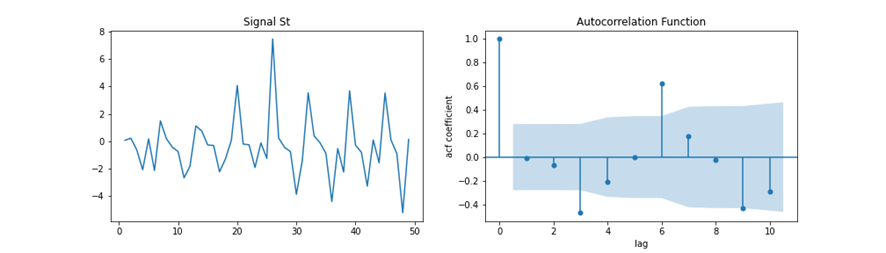

## **ARMA Definition**
ARMA(p, q) is a combination of AR(p) and MA(q) models. For example, ARMA(3,3) of signal the St can be formulated as

`St = β0 + β1St-1 + β2St-2 + β3St-3 + ϵt + γ1ϵt-1 + γ2ϵt-2 + γ3ϵt-3`

where β, γ are coefficients and ϵ error. We already described the way of choosing order p and q in the section for AR and MA models.

## Since our search space is not big, **usually values p and q are not higher than 10**.
- We will only test values up to 10.

Notice that, for spikes in the limiar region of the 95% confidence interval, it is also interesting to analyze their decay rate: **when the inclination of the vertical values (decay rate of the autocorrelation) suddenly decreases, we should stop considering the influence of the lags** (i.e., we stop counting the lags when the derivative suddenly changes).
- For instance: there may be an abrupt change of derivative from lag = 6 in the ACF plot: the values of the ACF becomes approximately constant, and a baseline is reached. 

## p = spikes on PACF plot that are outside the error (blue region).
- For instance, if there are spikes in both lag = 1 and lag = 2, then p = 2, or p = 1.
    
## In its turn, q represents the lags where spikes of ACF plot that are outside blue region.
- For instance, if all spikes until lag = 6 are outside the blue region, then q = 1, 2, 3, 4, 5, 6.

## **Interpretation - Background**

To find the best combination (p,q), we can apply a popular technique for hyperparameter optimization called grid search. Grid search is simply an exhaustive search through a manually specified subset of the hyperparameter space of a learning algorithm. 
- Basically, it means that this method will try each combination of p and q from the specified subset that we provided.

Also, in order to find the best combination of p and q, we need to have some **objective function that will measure model performance on a validation set.**  
- Usually, we can use **AIC and BIC** for that purpose. 

#### **The lower the values of these criteria, the better the model is.**

### **Akaike Information Criteria (AIC)**
**AIC stands for Akaike Information Criteria, and it is a statistical measure that we can use to compare different models for their relative quality.** 
- It measures the quality of the model in terms of its goodness-of-fit to the data, its simplicity, and how much it relies on the tuning parameters. The formula for AIC is:

`AIC = 2k - 2l`
 
where l is a log-likelihood, and k is a number of parameters. For example, the AR(p) model has p+1 parameters.
- AIC prefers a **higher log-likelihood** that indicates how strong the model is in fitting the data, and a **simpler model in terms of parameters.**

### **Bayesian Information Criteria (BIC)**
In addition to AIC, the BIC (Bayesian Information Criteria) uses one more indicator **n that defines the number of samples used for fitting.** The formula for BIC is:

`BIC = klog(n) - 2l`
 
### **Cross-Validation for Time-Series**
Finally, since we are dealing with time series, we would need to utilize appropriate validation techniques for parameter tuning. This is important because we want to simulate the real-time behavior of the data flow. 
- For instance, it would not be correct to use a data sample xi to predict data sample xj, if xj comes before xi by time. That is because in real life we cannot use information from the future to predict data in real-time.
- Thus, one popular validation technique used for tuning time-series-based machine learning models is cross-validation for time-series. The goal is to see which hyperparameters of the model give the best results in terms of our selected measurement metric on the training data. Then, we use that model for future predictions.
For example, if our data consist of five time-points, we can make a train-test split as:
•	Training [1], Test [2]
•	Training [1, 2], Test [3]
•	Training [1, 2, 3], Test [4]
•	Training [1, 2, 3, 4], Test [5]
Of course, one time-point might not be enough as the starting training set, but instead of one, we can start with n starting points and follow the same logic.

# **ARIMA Models - Time Series Analysis Handbook - Background**

ARIMA models are built given the following key aspects:

**AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.  
**I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.  
**MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used:  
**p**: The number of lag observations included in the model, also called the lag order (_deals with **window** of $X\_t$_)  
**d**: The number of times that the raw observations are differenced, also called the degree of differencing (_deals with order of **differencing** of $X\_t$_)  
**q**: The size of the moving average window, also called the order of moving average (_deals with **residuals**_)

Given this, the general case of _**ARIMA(p,d,q)**_ can be written as:

\\begin{equation} X\_{t} = \\alpha _{1}X_{t-1} + \\dots + \\alpha _{p}X_{t-p} + \\varepsilon _{t}+\\theta_{1}\\varepsilon \_{t-1}+\\cdots +\\theta \_{q}\\varepsilon \_{t-q} \\end{equation}

Or in words :

**Predicted $X\_t$** = Constant + Linear combination of **Lags of $X$ (up to $p$ lags)** + Linear Combination of **Lagged forecast errors (up to q lags)**. Provided that the time-series is already **differenced (up to d terms)** to ensure stationarity.

#### Finding the order differencing _d_

As stated before, ARIMA models are assumed to be stationary. Implementing differencing may induce stationarity for various time series. The quickest way to determine _d_ for our models is to difference and simply run ADF to check for stationarity. We can also look at the PACF and ACF to see if our time series is stationary after _d_ differencing.

To illustrate, let's take a look at the following example:


Initial eyeballing shows that there is a trend for this time series and is non-stationary.  Checking the ADF:

```
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
```



```
ADF Statistic: -2.464240
p-value: 0.124419
```

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary. For our example, we fail to reject the null hypothesis.

Next we difference our time series and check the results of the ADF test. We will also look at the ACF.

```
plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

print('ADF Statistic for 1st Order Differencing')
result = adfuller(df.value.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

print('\n ADF Statistic for 2nd Order Differencing')
result = adfuller(df.value.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
```

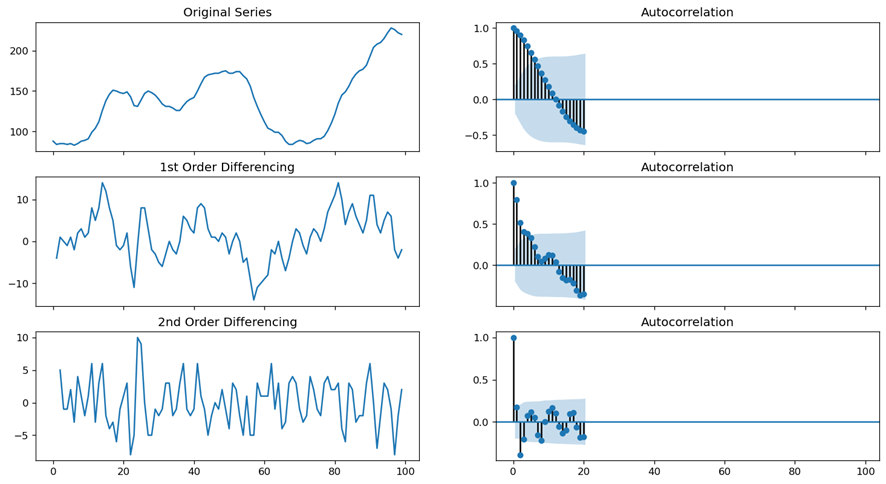

```
ADF Statistic for 1st Order Differencing
ADF Statistic: -2.722238
p-value: 0.070268
Critical Values:
    1%: -3.500
    5%: -2.892
    10%: -2.583

 ADF Statistic for 2nd Order Differencing
ADF Statistic: -9.929762
p-value: 0.000000
Critical Values:
    1%: -3.500
    5%: -2.892
    10%: -2.583

```

Given the results of our ACF and ADF, **we can see that our time series reaches stationarity after two orders of differencing. However, the ACF of the 2nd order differencing goes into the negative zone fairly quick. This can indicates that the series might have been over differenced. It is now up to us if we want consider the first or second order differencing for our ARIMA models.**

**\- Then, d = 1 or d = 2.**

\- If d = 0, we are using ARMA model.

## **The value of "d" corresponds to the total of differentiations for making the process stationary.**

# **Time series seasonal decomposition - Background**

- decomposition_mode = "additive" - manipulate the parameter 'model' from seasonal_decompose.
- Alternatively, set decomposition_mode = "multiplicative" for decomposing as a multiplicative time series.

### **'additive' model**
- An additive model suggests that the components are added together as: 

`y(t) = Level + Trend + Seasonality + Noise`

- An additive model is linear where changes over time are consistently made by the same amount. 
- A linear trend is a straight line. 
- A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).
    
### **'multiplicative' model** 
- A multiplicative model suggests that the components are multiplied together as:

`y(t) = Level * Trend * Seasonality * Noise`

- A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.
- A nonlinear trend is a curved line. 
- A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.

Check:
https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/#:~:text=The%20statsmodels%20library%20provides%20an%20implementation%20of%20the,careful%20to%20be%20critical%20when%20interpreting%20the%20result